# What Makes Some Writers' Voices So Distinct?: a Stylometric Classification Project

The holy grail for any writer is to have a voice so distinct that readers could recognize it in a given text without knowing who wrote it. But what makes a voice that distinct? To answer that question, I proceeded along two steps. 

1. Build a model that could, first, quantitatively identify modern authors who have a distinct voice. I'll do this by gathering the books of several different authors, training a classification model with their labeled writing samples, and then seeing how well the model can attribute unlabeled writing samples back to those authors. The more acccurate the model it is for a given author's texts, the more distinct the voice, we'll presume. 


2. Inspect the model to learn what makes those authors' voices so recognizable. I'll use feature importance scores, and then using EDA to guide this exploratory analysis.

# Step One: Import Author's Texts into a Dataframe

We'll begin by reading the books of 7 nonfiction authors into a dataframe.

In [ ]:
# Start with a whole host of imports we'll use throughout

import nltk, re, pprint
from nltk import word_tokenize, sent_tokenize
from urllib import request
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statistics
import math
import re
import string
from sklearn.metrics.pairwise import cosine_similarity
import copy

pd.set_option("display.max_rows", 400)
pd.set_option("display.max_colwidth", 150)
pd.set_option("display.max_columns", 400)

In [23]:
# Read our authors' texts into a dataframe

def read_files_into_df(filenames, authors):
    texts = {}
    for index, file in enumerate(filenames):
        with open(file) as f:
            texts[authors[index]] = f.read()
    df = pd.DataFrame.from_dict(texts, orient="index")
    return df

authors = ["Harris", "Dawkins", "Pinker", "Gladwell", "Kahneman", "Diamond", "Taleb"]
filenames = ["stylometry/harris.txt", 
             "stylometry/dawkins.txt",
            "stylometry/pinker.txt",
            "stylometry/gladwell.txt",
            "stylometry/kahneman.txt",
            "stylometry/diamond.txt",
            "stylometry/taleb.txt"]
n = 500
df = read_files_into_df(filenames, authors)

# Step Two: Clean and Process the Texts

Because paragraph and sentence length differ within texts and among texts, let's chop up each one of our texts into 500-word documents. Then, so we have a class-balanced dataset, we'll trip the number of rows for each author to the group minimum.

In [8]:
# Tokenize texts into words 

def tokenize_texts(text):
    remove_words = ["s", "t"]
    tokens = word_tokenize(text)
    tokens = ([token for token in tokens if any(c.isalpha() for c in token)])
    tokens = [token for token in tokens if token not in remove_words]
    return tokens
df[0] = df[0].apply(tokenize_texts)


# Combine sentences into 500-word segments.

def combine_sentences(sentences, n):
    sentence_chunks = [sentences[i * n:(i + 1) * n] for i in range((len(sentences) // n ))]  
    sentence_chunks = [" ".join(chunk) for chunk in sentence_chunks]
    return sentence_chunks
df[0] = df[0].apply(combine_sentences, n = n) 


# Rename columns and reshape df

df = df.rename(columns={0: "text"})
df = df.reset_index()
df = df.explode("text")
 
    
# Re-tokenize 500 word segments back into words

df["text"] = df["text"].apply(tokenize_texts)
df = (df.reset_index()
     .drop(columns="level_0")
     .rename(columns={"index": "author"}))


# Trim number of rows for each author to the group minimum to ensure a class-balanced set 

def even_rows(df):

    minimum = df["author"].value_counts().min()

    def take_minimum_rows(sent_list):
        new_list = list(sent_list)[:minimum]
        return new_list
    
    df = df.groupby("author").agg({"text": take_minimum_rows})

    df = df.reset_index()
    df = df.explode("text")
    df = df.reset_index()
    df = df.drop(columns='index')

    return df
df = even_rows(df)

# Step Three: Calculate Skipgram Frequencies

According to the author attribution literature, one feature that is often successful for distinguishing between writers are part of speech skipgrams. In this step, we'll find the top skipgrams across all texts, and then find the relative skipgram frequency (z-scores) for each particular author.

In [11]:
# Find skipgrams for each corpora

def find_skipgrams(text):
    skipgram_list = []
    tokens = text
    pos_tokens = nltk.pos_tag(tokens)
    pos_tags = [element[1] for element in pos_tokens]
    skipgrams = list(nltk.skipgrams(pos_tags, 3, 2))
    return skipgrams
df["skipgrams"] = df["text"].apply(find_skipgrams)


# Combine skipgram list for each known author into one single list

def combine_skipgrams(skipgram_series):
    import functools 
    skipgram_list = skipgram_series.to_list()
    skipgram_total = functools.reduce(lambda x,y: x+y, skipgram_list)
    return skipgram_total

skipgram_total = combine_skipgrams(df["skipgrams"])
  
    
# Filter list for 100 most common skipgrams

def get_top_100(skipgram_total):
    import collections
    ctr = collections.Counter(skipgram_total)
    skipgram_100 = []
    for skipgram, count in ctr.most_common(100):
        skipgram_100.append(skipgram)
    return skipgram_100
skipgram_100 = get_top_100(skipgram_total)
    
    
# Create a dictionary that houses the top 100 skipgram frequencies for each author 

def get_skipgram_freqs(skipgrams, skipgram_100):
    skipgram_freqs = {}
    overall = len(skipgrams)
    for skipgram in skipgram_100:
        presence = skipgrams.count(skipgram)
        skipgram_freqs[skipgram] = presence/overall
    return skipgram_freqs
df["skipgram_freqs"] = df["skipgrams"].apply(get_skipgram_freqs, skipgram_100 = skipgram_100)


# Combine skipgram freqs across authors to get averages and standard deviations

def get_total_mean_and_std(df, skipgram_100):
  
    skipgram_totals = {}
    for skipgram in skipgram_100:
    
        skipgram_totals[skipgram] = {}
        skipgram_sum, skipgram_list = 0, []
    
        for index, freq_dict in df["skipgram_freqs"].iteritems():
            skipgram_sum+=freq_dict[skipgram]
            skipgram_list.append(freq_dict[skipgram])

        skipgram_totals[skipgram]["mean"] = skipgram_sum/len(df)
        skipgram_totals[skipgram]["std"] = statistics.stdev(skipgram_list)
    
    return skipgram_totals
skipgram_totals = get_total_mean_and_std(df, skipgram_100)
    

# Create a dictionary that stores z-scores for each author

def get_zscores(skipgram_freqs, skipgram_totals):
    z_scores = {}
    for skipgram, values in skipgram_totals.items():
            actual = skipgram_freqs[skipgram]
            mean = skipgram_totals[skipgram]["mean"]
            std = skipgram_totals[skipgram]["std"]
            z_scores[skipgram]= (actual - mean)/std
    return z_scores
df["skipgram_zscores"] = df["skipgram_freqs"].apply(get_zscores, skipgram_totals = skipgram_totals)

# Step Four: Calculate Function Word Frequencies

Another feature that is often successful for distinguishing between writers, according to the author attribution literature, is function word (aka filler or stop words) frequencies. In this step, we'll find the top function across all texts, and then find the relative function words frequency (z-scores) for each particular author.

In [12]:
# Combine corpora

def combine_corpora(text_series):
    import functools 
    text_list = text_series.to_list()
    text_total = functools.reduce(lambda x,y: x+y, text_list)
    return text_total
whole_corpus = combine_corpora(df["text"])
    
    
# Get top words

def get_top_words(whole_corpus):
    whole_corpus_freq_dist = list(nltk.FreqDist(whole_corpus).most_common(40))
    top_words = [word for word,freq in whole_corpus_freq_dist]
    return top_words
top_words = get_top_words(whole_corpus)
    
    
# Get word frequencies

def get_word_freqs(words, top_words):
    word_freqs = {}
    overall = len(words)
    for word in top_words:
        presence = words.count(word)
        word_freqs[word] = presence/overall
    return word_freqs
df["word_freqs"] = df["text"].apply(get_word_freqs, top_words = top_words)


# Combine word freqs across authors to get averages and standard deviations

def get_total_mean_and_std_words(df, top_words):
  
    word_totals = {}
    for word in top_words:
    
        word_totals[word] = {}
        word_sum, word_list = 0, []
    
        for index, freq_dict in df["word_freqs"].iteritems():
            word_sum+=freq_dict[word]
            word_list.append(freq_dict[word])

        word_totals[word]["mean"] = word_sum/len(df)
        word_totals[word]["std"] = statistics.stdev(word_list)
    
    return word_totals
word_totals = get_total_mean_and_std_words(df, top_words)


# Create a dictionary that stores z-scores for function words for each author

def get_zscores_words(word_freqs, word_totals):
    z_scores = {}
    for word, values in word_totals.items():
            actual = word_freqs[word]
            mean = word_totals[word]["mean"]
            std = word_totals[word]["std"]
            z_scores[word]= (actual - mean)/std
    return z_scores
df["function_zscores"] = df["word_freqs"].apply(get_zscores_words, word_totals = word_totals)

# Step Five: Create New Dataframe with Appended Skipgram and Function Word Z-Scores

Here, we'll put our features (skipgram and function word z-scores derived in the last two steps) and our target (author name) in one dataframe that we'll soon use for modeling.

In [13]:
zscore_list_skipgrams = df["skipgram_zscores"].to_list()
zscore_list_function = df["function_zscores"].to_list()
df_skipgrams = pd.DataFrame(zscore_list_skipgrams)
df_function = pd.DataFrame(zscore_list_function)
df_new = pd.concat([df_skipgrams, df_function, df["author"]], axis=1)

# Step Six: Run the Model to Determine Which Author has the Most Predictable Texts

We'll now run a gradient boosting model to learn how accurate the model is overall, and more importantly, the accuracy of the model for particular authors -- we'll use these scores as a proxy for distinctiveness of voice. While the model achieved a 75% accuracy overall, it was able to classify Malcolm Gladwell's writing with 92% accuracy.

overall accuracy:  0.746268656716418
             match
author            
Dawkins   0.724138
Diamond   0.859649
Gladwell  0.929825
Harris    0.824561
Kahneman  0.637931
Pinker    0.741379
Taleb     0.508772


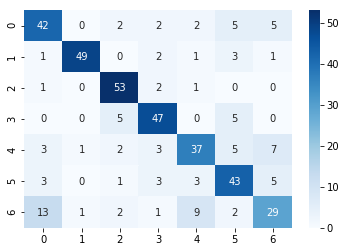

In [14]:
def run_model(df_new):

    from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, fbeta_score
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix 
    from sklearn.metrics import classification_report
    import seaborn as sns


    X = df_new.iloc[:,0:140]
    y = df_new.iloc[:,140]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

    gb = GradientBoostingClassifier(n_estimators=30000, learning_rate = .10, max_depth = 7, random_state = 0)
    gb.fit(X_train, y_train)
    test_pred = gb.predict(X_test)
    
    print("overall accuracy: ", accuracy_score(y_test, test_pred))
    results = confusion_matrix(y_test, test_pred)
    sns.heatmap(results, annot=True, cmap="Blues");

    df_results = pd.DataFrame(y_test)
    df_results["prediction"] = test_pred
    df_results["match"]=(df_results["author"]==df_results["prediction"])
    print(df_results.groupby("author").agg({"match":"mean"}))
    
    return gb

gb = run_model(df_new)

# Step Seven: Get Feature Importances to See How the Model Distinguished Among Different Authors

Here we'll check feature importance scores and see that what tops the list is the skipgram JJ,JJ,NNS -- which Gladwell, second to only Jared Diamond, uses more often than any other author. Another notable feature that doesn't appear quite as high on the list is the word "what" but EDA shows that our target author uses the word with really high frequency. In the next section, we'll explore Gladwell's use of these features to see if we can learn more about how they contribute to his distinct voice.

In [15]:
features = pd.Series(df_new.columns)[:-1]
df_features = pd.DataFrame(features)
df_features["importance"]= gb.feature_importances_
df_features = df_features.sort_values("importance", ascending=False)
df_features.reset_index()

,index,0,importance
0,70,"(JJ, JJ, NNS)",0.063984
1,113,not,0.036501
2,122,their,0.036360
3,126,he,0.032444
4,106,is,0.023685
5,110,are,0.023006
6,101,of,0.021903
7,123,you,0.021881
8,41,"(NNS, IN, JJ)",0.021668
9,105,that,0.018523


In [280]:
df_zscore_agg = df_new.groupby("author").agg("mean")
pd.set_option("display.max_columns", 400)
df_zscore_agg.sort_values(by="Gladwell", axis=1, ascending=False)

,he,was,what,"(IN, NN, PRP)","(DT, NN, VBD)",not,"(NN, IN, NNS)",at,"(IN, JJ, NNS)","(JJ, IN, NNS)",by,"(NN, NN, VBD)","(IN, NNS, IN)","(JJ, NNS, IN)","(NNS, IN, JJ)",his,"(IN, NN, NNS)","(NNS, JJ, NN)","(NN, JJ, NNS)","(NNS, IN, NN)","(NN, IN, PRP)","(IN, NN, JJ)","(IN, DT, JJ)",you,"(JJ, NNS, NN)","(JJ, NN, DT)","(IN, NN, VBD)","(NN, IN, JJ)","(JJ, IN, JJ)","(JJ, NN, NNS)","(JJ, NNS, JJ)","(IN, JJ, IN)",of,"(JJ, NN, JJ)","(JJ, NN, IN)","(JJ, JJ, NNS)","(NNS, IN, NNS)","(JJ, IN, DT)","(IN, JJ, NN)","(DT, JJ, IN)","(JJ, IN, NN)","(NN, NNS, IN)","(NN, DT, JJ)","(IN, JJ, JJ)","(DT, JJ, NNS)","(DT, JJ, NN)","(IN, IN, JJ)","(NNS, IN, DT)",they,on,"(VBN, IN, NN)",and,"(JJ, NN, VBD)",were,"(DT, NN, NNS)",it,"(NNS, DT, NN)",are,had,"(DT, NNS, IN)","(NN, JJ, NN)","(JJ, JJ, NN)",from,"(IN, NN, IN)","(IN, DT, NNS)","(DT, IN, JJ)",for,we,as,"(DT, NN, JJ)","(NN, MD, VB)",when,"(IN, NN, DT)","(JJ, NN, CC)",be,"(NN, VBZ, JJ)","(JJ, DT, NN)","(NN, NN, NNS)",that,in,"(IN, DT, IN)","(JJ, NN, NN)","(NN, IN, IN)","(NN, DT, IN)",is,"(NN, IN, DT)","(DT, NN, IN)",this,have,"(JJ, NN, VBZ)","(NN, NN, DT)","(IN, IN, NN)",the,"(NN, NN, JJ)","(NN, NN, NN)","(JJ, NN, RB)","(IN, NN, VBZ)","(VB, IN, NN)","(IN, IN, DT)","(NN, NN, IN)","(DT, NN, NN)","(DT, NN, VBZ)","(IN, NN, RB)","(DT, NN, RB)",their,"(DT, IN, NN)",if,people,an,"(NN, NN, CC)",one,"(RB, IN, NN)","(NN, IN, NN)",more,"(RB, IN, DT)","(NN, DT, NN)","(TO, VB, IN)",or,to,"(DT, NN, DT)","(RB, DT, NN)","(DT, IN, DT)","(NN, NN, VBZ)","(TO, VB, NN)","(IN, NN, CC)","(NN, CC, NN)","(NN, RB, IN)","(DT, NN, CC)","(NN, NN, RB)",can,"(IN, NN, NN)",but,"(NN, TO, VB)","(VB, DT, NN)",with,"(VB, NN, IN)","(NN, VBZ, IN)","(RB, JJ, NN)","(IN, DT, NN)",who
author,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Dawkins,0.045511,0.101418,0.002639,0.103150,0.235745,0.181022,0.334883,0.163791,0.366256,0.290803,0.235989,0.131296,0.336006,0.368783,0.377907,0.284668,0.321822,0.350250,0.322469,0.431738,0.266391,0.287490,0.161299,0.156997,0.223612,0.350972,0.160148,0.319800,0.003147,0.327054,0.349249,0.103351,0.253964,0.155505,0.460818,0.267463,0.555795,0.172664,0.363796,0.276248,0.312967,0.335496,3.290861e-01,0.039309,0.347817,0.459822,0.038759,0.430114,0.400030,0.101311,0.175178,0.567443,0.100597,0.318623,0.332289,0.536443,0.333350,0.247470,0.220766,0.425825,0.476442,0.240581,0.008100,0.454477,0.429698,0.045782,0.067571,0.042249,0.271559,0.185474,0.437757,0.238117,0.167279,0.006891,0.425590,0.335708,0.115919,0.224760,0.046512,0.031043,0.238588,0.385246,0.352435,0.234018,0.592614,0.350091,0.423041,0.247876,0.121340,0.417608,0.317932,0.318646,0.040174,0.215643,0.263049,0.411770,0.325585,0.331863,0.026055,0.538971,0.295780,0.224787,0.499795,0.276655,0.330308,0.290101,0.169561,0.340592,0.099377,0.164798,0.008101,0.298750,0.621682,0.266764,0.101112,0.320714,0.163677,0.047001,0.031643,0.152897,0.281939,0.089123,0.369951,0.159090,0.134909,0.122903,0.313237,0.047706,0.345005,0.004392,0.373018,0.229721,0.244570,0.276932,0.129155,0.276832,0.246011,0.491281,0.287709,0.043903
Diamond,0.513224,0.279932,0.582275,0.804918,0.115043,0.573973,0.565616,0.056655,1.420497,0.845753,0.461698,0.152281,0.985060,1.467614,1.447538,0.483712,0.831185,1.068190,1.237975,0.965547,0.811881,0.697891,0.884476,0.594778,1.126517,0.340945,0.116711,0.894591,1.128874,1.290117,1.350986,0.962843,0.540719,0.896910,0.578309,1.546296,0.984153,0.595692,0.854349,0.521634,0.609376,1.062037,4.425000e-01,1.318492,1.120966,0.355935,0.837857,0.791339,0.447457,0.192560,0.240215,0.679079,0.399012,0.453425,0.305934,0.890941,0.287024,0.551806,0.158533,0.517585,0.452024,0.969054,0.474086,0.086442,0.466540,0.692299,0.284662,0.393061,0.174112,0.333314,0.547904,0.432687,0.105773,0.687092,0.628613,0.510645,0.152516,0.841948,0.656359,0.182556,0.071180,0.591941,0.092793,0.187055,1.051128,0.057971,0.397124,0.662893,0.085783,0.412790,0.026782,0.065178,0.298399,0.545042,0.105912,0.422606,0.69813

# Step Eight: Analyze Gladwell Use of JJ-JJ-NNS

Let's take a moment to look at Malcolm Gladwell's use of this skipgram. I wrote a function that highlights the sequence every time it occurs in the text. It looks as though Gladwell goes out of his way to use this beautifully balanced construction often, even at the sacrifice of using redundant words, like when he writes "several different styles and several different places."

In [18]:
file = "stylometry/gladwell.txt"
with open(file) as f:
    gladwell = f.read()

def highlight_skipgrams(text, skipgram):
    skipgram_list = []
    tokens = text
    pos_tokens = nltk.pos_tag(tokens)
    string_list = []
    other_list = []
    counter = 0
    for i in range(len(pos_tokens)-2):
        if ([pos_tokens[i][1], pos_tokens[i+1][1], pos_tokens[i+2][1]] == skipgram):
            string_list.extend(["******", pos_tokens[i][0], pos_tokens[i+1][0], pos_tokens[i+2][0], "******"])
            other_list.append([pos_tokens[i][0], pos_tokens[i+1][0], pos_tokens[i+2][0]])
            i+=3
            counter+=1
        else:
            string_list.append(pos_tokens[i][0])   
    highlighted_text = " ".join(string_list)
    print(highlighted_text)

skipgram = ['JJ', 'JJ', 'NNS']    
text = word_tokenize(gladwell)
highlight_skipgrams(text, skipgram)

introduction the statue that didn look right in september of an art dealer by the name of gianfranco becchina approached the paul getty museum in california he had in his possession he said marble statue dating from the sixth century bc it was what is known as kouros sculpture of nude male youth standing with his left leg forward and his arms at his sides there are only about two hundred kouroi in existence and most have been recovered badly damaged or in fragments from grave sites or archeological digs but this one was almost perfectly preserved it stood close to seven feet tall it had kind of light colored glow that set it apart from other ancient works it was an extraordinary find becchina asking price was just under million the getty moved cautiously it took the kouros on loan and began thorough investigation was the statue consistent with other known kouroi the answer appeared to be yes the style of the sculpture seemed reminiscent of the anavyssos kouros in the national archaeolo

# Step Nine: Analyze Gladwell Use of the function word "what"

Gladwell also uses the word "what" with stunning frequency even when efficiency suggests that he shouldn't. For example when he writes: "Researchers have settled on what they believe is the magic number for true expertise..." he could have just written: "Researchers believe they have settled on the magic number for true expertise...", saving a couple of words.

In [22]:
def highlight_words(text, word):
    word_list = []
    for item in text:
        if item == word:
            word_list.extend(["***** ", item, " *****"])
        else:
            word_list.append(item)
    new_text = " ".join(word_list)
    print(new_text)
    
highlight_words(text, "what")

introduction the statue that didn look right in september of an art dealer by the name of gianfranco becchina approached the paul getty museum in california he had in his possession he said marble statue dating from the sixth century bc it was *****  what  ***** is known as kouros sculpture of nude male youth standing with his left leg forward and his arms at his sides there are only about two hundred kouroi in existence and most have been recovered badly damaged or in fragments from grave sites or archeological digs but this one was almost perfectly preserved it stood close to seven feet tall it had kind of light colored glow that set it apart from other ancient works it was an extraordinary find becchina asking price was just under million the getty moved cautiously it took the kouros on loan and began thorough investigation was the statue consistent with other known kouroi the answer appeared to be yes the style of the sculpture seemed reminiscent of the anavyssos kouros in the nati

# Conclusion

My analysis suggests that we can, in fact, quantitatively identify modern authors who have distinct voices, using just two kinds of features: function word and part of speech skipgram frequency. It also suggests that Malcolm Gladwell has a very distinct voice, in part, because he doesn't always follow Strunk and White's dictum of "omit needless words" but instead chooses constructions probably, because they reflect his one unique personality.